In [17]:
import numpyro
import numpyro.distributions as dist
import jax.random as random
import einops
import jax
import jax.numpy as jnp


def get_example_image(image_shape, sv_r, indexes_of_high, mean_0,var_0,mean_1,var_1,rng_key).
    """
    we will create a simulation of the image with supervoxel segmentation each super voxel 
    at first extremely simplified case with square supervoxels each filled with predefined gausiians output
    we will generate couple of such and try to make a graph model that would recognize the diffrences
    indexes_of_high - will be a set of tuples indicating w and  h coordinates
    """ 
    #1)create empy image
    image= jnp.zeros(image_shape)
    #2) reshape to get as las two dims sv size
    image= einops.rearrange(image, '(w sw) (h sh) ->w h sw sh', sw=sv_r,sh=sv_r )
    image=numpyro.sample('mu', dist.Normal(mean_0,var_0), sample_shape=image.shape,rng_key=rng_key)
    #populate the sv areas with goussian noise of mean and var 1 if index is in indexes_of_high and mean and var 0 otherwise
    rng_key_new, old= random.split(rng_key)
    for coord in indexes_of_high.
        rng_key_new, old= random.split(rng_key_new)
        x,y=coord
        image.at[x,y,.,.].set(numpyro.sample('mu_1', dist.Normal(mean_1,var_1), sample_shape=(sv_r,sv_r),rng_key=rng_key_new))

    #reshape back to original image shape
    image= einops.rearrange(image, 'w h sw sh -> (w sw) (h sh) ', sw=sv_r,sh=sv_r )
    return image

rng_key = random.PRNGKey(3)
rng_key_new,old = random.split(rng_key)

mean_0 =1
var_0=1
mean_1=2
var_1=0.5
image_shape=(64,64)
sv_r=8
indexes_of_high=[(0,0), (1,1), (2,2)]
get_example_image(image_shape, sv_r, indexes_of_high, mean_0,var_0,mean_1,var_1,old)
v_get_example_image=jax.vmap(get_example_image,in_axes=(None,None,None,None,None,None,None,0))

#                             ,in_axes=(0, 0,0)

In [20]:
def build_example_dataset().
    """ 
    using get_example_image  we will create multiple instances of diffrent images - we will save images
    task here will be graph level predictions 
    """
    num_per_class=50
    mean_0 =1
    var_0=1
    mean_1=2
    var_1=0.5
    image_shape=(64,64)
    sv_r=8
    a=v_get_example_image(image_shape, sv_r, [(0,0), (1,1), (2,2), (3,3)], mean_0,var_0,mean_1,var_1,random.split(rng_key_new,num_per_class  ))
    b=v_get_example_image(image_shape, sv_r, [(0,0), (0,1), (0,2), (0,3)], mean_0,var_0,mean_1,var_1,random.split(rng_key_new,num_per_class  ))
    c=v_get_example_image(image_shape, sv_r, [(0,0), (1,1), (0,1), (1,1)], mean_0,var_0,mean_1,var_1,random.split(rng_key_new,num_per_class  ))
    images=jnp.concatenate([a,b,c],axis=0)
    labels_a= jnp.ones(num_per_class)
    labels_b= jnp.ones(num_per_class)*2
    labels_c= jnp.ones(num_per_class)*3
    labels= jnp.concatenate([labels_a,labels_b, labels_c])
    return images,labels

dummy_dataset=build_example_dataset()
dummy_dataset[0].shape

(150, 64, 64)

In [40]:
def translate_mask_in_axis(mask.jnp.ndarray, axis.int,is_forward.int,mask_shape).
    translation_val=1
    mask= jnp.take(mask, indices=jnp.arange(translation_val*(1-is_forward),mask_shape[axis]-translation_val* is_forward),axis=axis )
    to_pad=jnp.array([[0,0],[0,0]])
    is_back=1-is_forward
    to_pad=to_pad.at[axis,is_back].set(translation_val)
    mask= jnp.pad(mask,to_pad)
    return mask


def get_indexes_of_adjacent(image_partitioned_shape).
    """ 
    adges will be static - not changable during training we will just connect neighbouring voxels
    image_partitioned_shape (w h sw sh)- the shape of the image partitioned into the supervoxels
    """
    w,h,sw,sh=image_partitioned_shape
    # we start from 1 in order to later filter 0 out
    indicies= jnp.arange(1,(w*h+1)).reshape((w,h))
    ein_string='f h w-> f (h w)' 
    a=einops.rearrange([indicies,translate_mask_in_axis(indicies.copy(),0,0,(w,h))],ein_string)
    b=einops.rearrange([indicies,translate_mask_in_axis(indicies.copy(),1,0,(w,h))],ein_string)
    c=einops.rearrange([indicies,translate_mask_in_axis(indicies.copy(),0,1,(w,h))],ein_string)
    d=einops.rearrange([indicies,translate_mask_in_axis(indicies.copy(),1,1,(w,h))],ein_string)
    print(a.shape)
    res= jnp.concatenate([a,b,c,d], axis=1)
    return res
print(f"dummy_dataset[0][0,.,.] {dummy_dataset[0][0,.,.].shape}")
image= einops.rearrange(dummy_dataset[0][0,.,.], '(w sw) (h sh) ->w h sw sh', sw=sv_r,sh=sv_r )
edges=get_indexes_of_adjacent(image.shape)
edges_ind=(edges==jnp.array([1,0]))
edges[edges_ind]

dummy_dataset[0][0,:,:] (64, 64)
(2, 64)


ValueError: Incompatible shapes for broadcasting: shapes=[(2, 256), (2,)]

In [54]:
# farid filters taken from SAR image edge detection: review and benchmark experiments
#something about farid can be found on https://github.com/kulvait/KCT_cbct/blob/4f89118513346f6a1b90a0b865ad077a1ffb9aca/src/alg/VolumeConvolutionOperator.cpp#L296
# and look https://github.com/search?q=farid+5x5x5&type=code

import jax.scipy as jsp
Farid_Gx=jnp.array([[0.004128,0.027308,0.046732,0.27308,0.004128]
          ,[0.010420,0.068939,0.117974,0.068939,0.010420   ]
          ,[0.0,0.0,0.0,0.0,0.0]
          ,[-0.010420,-0.068939,-0.117974,-0.068939,-0.010420   ]
          ,[-0.004128,-0.027308,-0.046732,-0.27308,-0.004128]          
        ])

Farid_Gy=jnp.transpose(Farid_Gx)

def apply_farid(image, f_filter):
    sobel= einops.rearrange(f_filter, 'x y-> 1 x y 1')
    image= einops.rearrange(image, 'x y-> 1 x y 1')

    return jsp.signal.convolve(image, sobel, mode='same')

def apply_farid_both(image):
    return apply_farid(image,Farid_Gx)**2 + apply_farid(image,Farid_Gy)**2

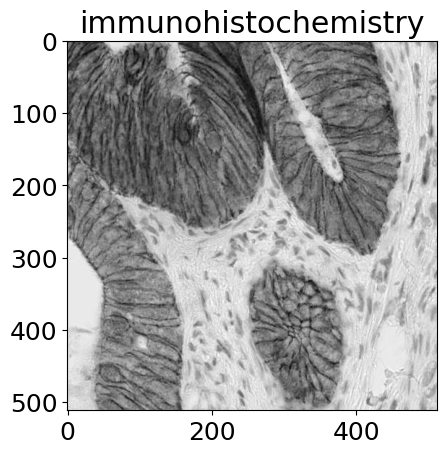

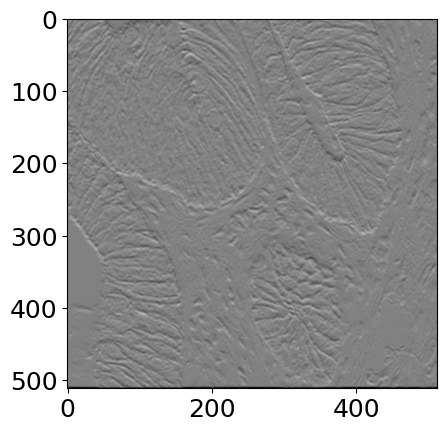

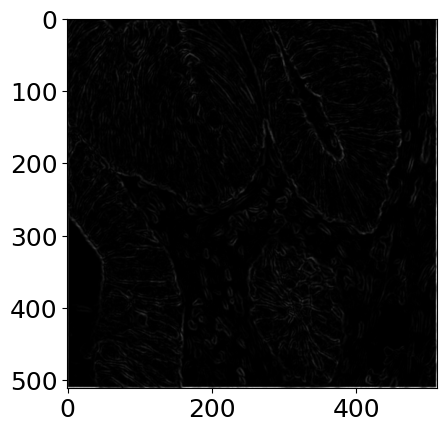

In [58]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from skimage import data

matplotlib.rcParams['font.size'] = 18


caller = getattr(data, 'immunohistochemistry')
plt.figure()
plt.title('immunohistochemistry')
image=np.sum(caller(),axis=-1)
plt.imshow(image, cmap=plt.cm.gray)
plt.show()
plt.imshow(apply_farid(image,Farid_Gx)[0,:,:,0], cmap=plt.cm.gray)
plt.show()
plt.imshow(apply_farid_both(image)[0,:,:,0] *100, cmap=plt.cm.gray)
plt.show()



In [ ]:
def get_graph_from_image_differentaible():
    """ 
    we will create a graph from a given image a procedure need to be differentiable
    """
    # first we need to encode the svs into tokens - we will flatten and apply dense
    
    #  now a bit harder we need to get the edges for now we will just connect with previous/next in each axis
    node_features = jnp.array([[0.], [2.], [4.], [6.]])
      senders = jnp.array([0, 1, 2, 3, 0])
  receivers = jnp.array([1, 2, 0, 0, 3])

In [ ]:
import jraph
import jax.numpy as jnp

# Define a three node graph, each node has an integer as its feature.
node_features = jnp.array([[0.], [1.], [2.]])

# We will construct a graph for which there is a directed edge between each node
# and its successor. We define this with `senders` (source nodes) and `receivers`
# (destination nodes).
senders = jnp.array([0, 1, 2])
receivers = jnp.array([1, 2, 0])

# You can optionally add edge attributes.
edges = jnp.array([[5.], [6.], [7.]])

# We then save the number of nodes and the number of edges.
# This information is used to make running GNNs over multiple graphs
# in a GraphsTuple possible.
n_node = jnp.array([3])
n_edge = jnp.array([3])

# Optionally you can add `global` information, such as a graph label.

global_context = jnp.array([[1]])
graph = jraph.GraphsTuple(nodes=node_features, senders=senders, receivers=receivers,
edges=edges, n_node=n_node, n_edge=n_edge, globals=global_context)